In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

# from skimage import data
from skimage import transform as tf
from skimage.transform import rotate

import cv2

MIN_CONTOUR_AREA = 30
RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30

SAMPLES_COUNT = 1002
SCORE_COLOR = [235,235,235]

# SAMPLE_FOLDER = 'F:\projlogs\gamcon_samples'
SAMPLE_FOLDER = "/mnt/hgfs/projlogs/gamcon_samples"

In [2]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

In [3]:
def show_raw(images, labels):
    fig, ax = plt.subplots(ncols=len(images), sharex=False, sharey=False)
    for i in range(len(images)):
        ax[i].imshow(images[i], cmap=plt.cm.gray)
        ax[i].axis('off')
        if labels is not None:
            ax[i].set_title(labels[i])

    plt.show()

In [4]:
def show_all(images, labels=None):
    if labels is not None:
        image_sets = list(grouper(images, 6, np.zeros(images[0].shape, dtype=np.int)))
        label_sets = list(grouper(labels, 6, ''))
        for i, image_set in enumerate(image_sets):
            show_raw(image_set, labels=label_sets[i])
    else:
        [ show_raw(z, ['']*6) for z in grouper(images, 6, np.zeros(images[0].shape, dtype=np.int)) ]

In [5]:
def preprocess_score_image(original, verbose=0):
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    if verbose > 0:
        plt.imshow(bw_image);
        plt.show();
    image = bw_image.copy()
    img_contours, npa_contours, npa_hierarchy = cv2.findContours(image,
                                                 cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_SIMPLE)

    digits = []
    not_original = original.copy()
    for i, npa_contour in enumerate(npa_contours):
        if cv2.contourArea(npa_contour) > MIN_CONTOUR_AREA:
            [intX, intY, intW, intH] = cv2.boundingRect(npa_contour)
            if verbose > 0:
                print(i, [intX, intY, intW, intH])
            cv2.rectangle(not_original, (intX, intY), (intX+intW,intY+intH), (0, 0, 255), 1)
            if verbose > 0:
                plt.imshow(not_original);
                plt.show();
            imgROI = image[intY:intY+intH, intX:intX+intW]
            resized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
            flattened = resized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))
            digits.append((intX, flattened,))

    flattened_digits =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT), dtype=np.int)
    for _, digit in sorted(digits, key=lambda z: z[0]):
        flattened_digits = np.append(flattened_digits, digit, 0)

    return flattened_digits

In [6]:
# load classifications
classifications = []
with open(os.path.join(SAMPLE_FOLDER, 'score_smaples_values.txt'), 'rt') as f:
    test = [ z.strip() for z in f.readlines()]
    classifications = list(itertools.chain.from_iterable(test))
    # classifications.extend([z for z in chars])

print(len(test), test[:15])
print(sum([len(z) for z in test]))
print(len(classifications), classifications[:15])

1002 ['0', '0', '0', '0', '0', '0', '4', '12', '12', '16', '20', '28', '28', '28', '28']
3175
3175 ['0', '0', '0', '0', '0', '0', '4', '1', '2', '1', '2', '1', '6', '2', '0']


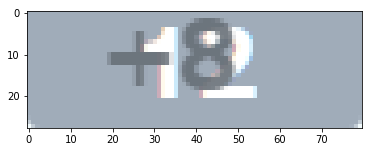

In [7]:
test_image = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_8.png'))
plt.imshow(test_image)

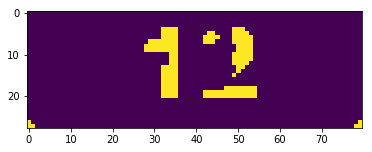

5 [28, 4, 8, 17]


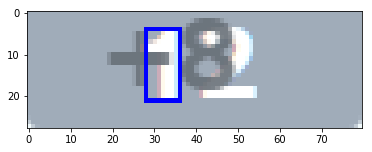

In [8]:
if MIN_CONTOUR_AREA < 30:
    MIN_CONTOUR_AREA = 30
parts = preprocess_score_image(test_image, verbose=1)

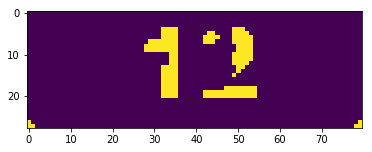

2 [42, 18, 13, 3]


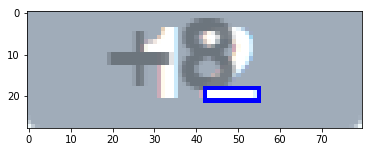

3 [42, 5, 4, 3]


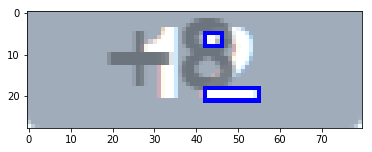

4 [49, 4, 5, 12]


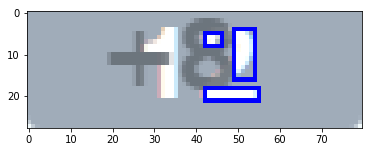

5 [28, 4, 8, 17]


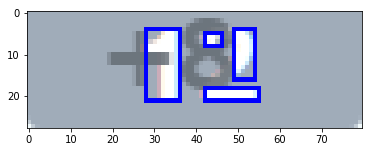

In [9]:
MIN_CONTOUR_AREA = 2
parts = preprocess_score_image(test_image, verbose=1)

In [10]:
test_image.shape

(28, 80, 3)

In [11]:
def col_filter(image, color, threshold=20):
    # filters specific color from the image
    lower = np.array([ z-threshold for z in color ])
    upper = np.array([ z+threshold for z in color ])
#     print('filtering by color range:', lower, upper)
    mask = cv2.inRange(image, lower, upper)
    res = cv2.bitwise_and(image, image, mask= mask)
    # cv2.GaussianBlur(res, (5,5), 0);
    res = cv2.medianBlur(res, 1);
    res = cv2.medianBlur(mask, 1);

    return res

In [12]:
def split_rois(image, color=[185, 172, 160], corner_cut_size=1, verbose=0):
    
    def find_range_start_end(sumlist):
        region_detected = False
        region_start = 0
        for i in range(len(sumlist)):
            if sumlist[i] > 0 and not region_detected:
                region_detected = True
                region_start = i

            if sumlist[i] == 0 and region_detected:
                break

        return region_start, i
    
    
    if verbose > 0:
        plt.imshow(image);
        plt.show();
        
    # filter by color
    workscreen = col_filter(image, color=color, threshold=20)
    
    if verbose > 0:
        plt.imshow(workscreen);
        plt.show();

    # sum over axis "0" i.e. sum the filterd color pixels in each column
    v_sums = workscreen.sum(0)
    if verbose > 0:
        print('h_sums lenght prior to corner cut:', len(v_sums))
    
    # cut corners (because of the round edges of the UI element, there are light color pixels in the corners of the img)
    v_sums = v_sums[corner_cut_size:-corner_cut_size]
    
    if verbose > 0:
        print(v_sums)
    
    zones = []
    consider_x = 0
    for delme in range(100):
        start_x, end_x = find_range_start_end(v_sums[consider_x:])
        
        # because find_range_start_end gives results relative to the input
        start_x +=  consider_x
        end_x += consider_x
        
        subimage = image[0:workscreen.shape[0], start_x:end_x + 1]
        consider_x = end_x + 1
        
        if verbose > 0:
            print(delme, start_x, end_x)
            
        zones.append([subimage, start_x, end_x])
        if start_x == consider_x or sum(v_sums[consider_x:]) == 0:
            break
    
    return zones

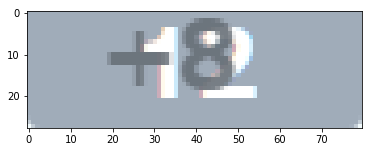

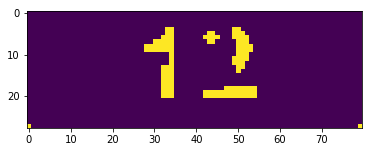

h_sums lenght prior to corner cut: 80
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  510
  510  765  765 3060 3570 4335    0    0    0    0    0    0    0  765
 1275 1275  765  510  765  765 2040 3570 3060 2295 1275  765    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
0 27 34
1 41 54
[[27, 34], [41, 54]]


In [13]:
zones = split_rois(test_image, color=[235,235,235], verbose=1)
print([z[1:] for z in zones ])
# plt.imshow(i);

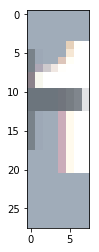

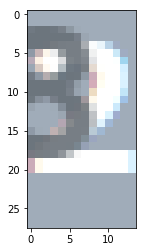

In [14]:
for sub in [ z[0] for z in zones ]:
    plt.imshow(sub);
    plt.show();

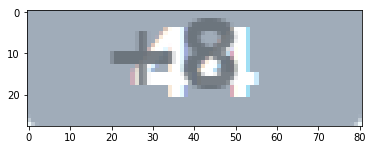

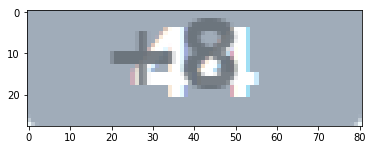

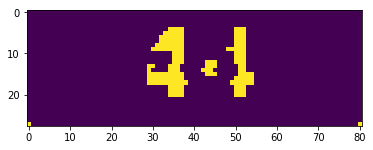

h_sums lenght prior to corner cut: 81
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 1275 1275 1275 1785 2040 3570 4335 4335 3825  255    0    0    0  255
 1020 1020  765    0    0  255  510 3570 4335 4335  765  765    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
0 28 38
1 41 45
2 47 54


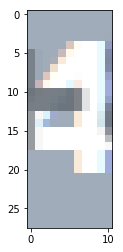

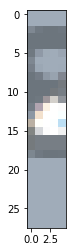

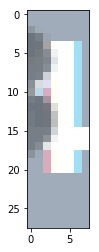

In [15]:
# ti2 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_344.png'))
# ti2 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_346.png'))
ti2 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_20.png'))
plt.imshow(ti2);
plt.show();
zones = split_rois(ti2, color=[235,235,235], verbose=1)
for sub in [ z[0] for z in zones ]:
    plt.imshow(sub);
    plt.show();

In [16]:
def merge_small_parts(zones, image, verbose=0):
    part_sizes = ([ z[2]-z[1] for z in zones ])
    new_zones = []
    
    if verbose > 0:
        print('# zones', len(zones))
    i = 1
    while i < len(zones) + 1:
        if verbose > 0:
            print('processing zones', i-1, '&', i)
        if part_sizes[i-1] < 7 and part_sizes[i] <= 11:
            subimage = image[0:image.shape[0], zones[i-1][1]:zones[i][2]+1]
            new_zones.append([subimage, zones[i-1][1], zones[i][2]])
            i += 1
            if verbose > 0:
                print('merged, thuse increased cycle to:', i-1, '&', i)
        else:
            new_zones.append(zones[i-1])
            
        i += 1
        if verbose > 0:
            print('ending=?', i, len(zones) +1, i == len(zones) +1 )
    
    if verbose > 0:
        print([z[1:] for z in new_zones])
    
    return new_zones  

In [17]:
def rois(image, corner_cut_size=1, verbose=0):
    zones = split_rois(image, color=SCORE_COLOR, corner_cut_size=corner_cut_size, verbose=verbose)
#     if verbose > 0:
#         print(len(zones))
    zones = merge_small_parts(zones, image, verbose=verbose)
#     if verbose > 0:
#         print(len(zones))
        
    return zones

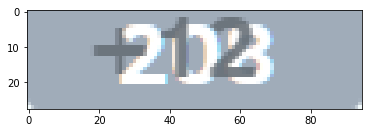

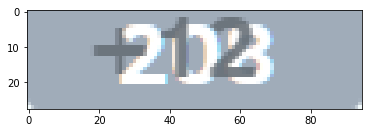

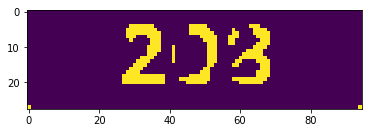

h_sums lenght prior to corner cut: 95
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  765 1785
 2550 2550 2550 2550 2295 3060 3315 2805 2295  765    0    0 1275    0
  255  255  510 1530 1530 1530 2040 2550 3825 2550 2040    0    0    0
  765 1785 1275 1020 1020 1275 1530 2295 3570 4080 3315 2295    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
0 26 38
1 40 41
2 42 53
3 56 68
# zones 4
processing zones 0 & 1
ending=? 2 5 False
processing zones 1 & 2
merged, thuse increased cycle to: 2 & 3
ending=? 4 5 False
processing zones 3 & 4
ending=? 5 5 True
[[26, 38], [40, 53], [56, 68]]


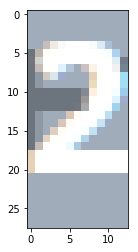

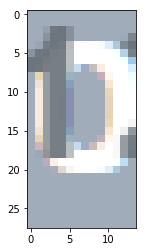

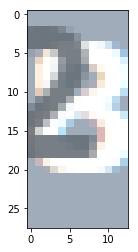

In [18]:
# ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_344.png'))
# ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_346.png'))
# ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_20.png'))
ti3 = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_43.png'))
plt.imshow(ti3);
plt.show();
# zones = split_rois(ti3, color=[235,235,235], verbose=1)
# zones = merge_small_parts(zones, ti3)
zones = rois(ti3, verbose=1)
for sub in [ z[0] for z in zones ]:
    plt.imshow(sub);
    plt.show();

In [19]:
FAIL HERE

SyntaxError: invalid syntax (<ipython-input-19-f2aac8727edc>, line 1)

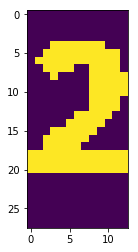

img smpls 1002


In [20]:
# load sample images
training_samples = []
training_images = []
flattened_images =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT), dtype=np.int)
classifications = []
for i in range(SAMPLES_COUNT):
    img = cv2.imread(os.path.join(SAMPLE_FOLDER, 'sample_' + str(i+1) + '.png'))
    # training_images.extend(preprocess_score_image(img))
    training_samples.append(img)
#     parts = preprocess_score_image(img)
    parts = rois(img)
    if len(test[i]) != len(parts):
        print(i, len(test[i]), len(parts), '(', test[i], ')')
        show_raw([img, img], None)
    else:
        for j, part in enumerate(parts):
            classifications.append(test[i][j])
            gray = cv2.cvtColor(part[0], cv2.COLOR_BGR2GRAY)
            _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
            if i==42 and j==0:
                plt.imshow(bw_image);
                plt.show();
            
            resized = cv2.resize(bw_image, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
            flattened = resized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))
            flattened_images = np.append(flattened_images, flattened, 0)
    training_images.extend(parts)

print('img smpls', len(training_samples))

In [21]:
# %%time
# print('sample digits:', len(flattened_images), 'labels:', len(classifications))
# classifications = [ int(z) for z in classifications]
# np.savetxt("overlapping_classifications.txt", classifications, fmt='%i')
# np.savetxt("overlapping_flattened_images.txt", flattened_images, fmt='%i')

sample digits: 3175 labels: 3175


In [ ]:
FAIL HERE

# LOAD AND TRAIN

In [22]:
# classifications = np.loadtxt("overlapping_classifications.txt") #, , fmt='%i')
with open('overlapping_classifications.txt', 'rt') as f:
    classifications = f.readlines()
flattened_images = np.loadtxt("overlapping_flattened_images.txt")#,  fmt='%i')

In [23]:
images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in flattened_images ]
classifications = [int(z.strip()) for z in classifications]

In [24]:
####  use this to output the loaded data  ####

# show_all(images, labels=classifications)

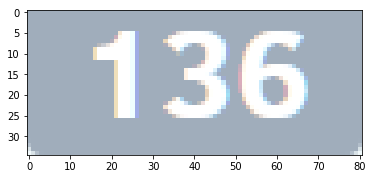

(35, 10, 3) (30, 20)
(35, 15, 3) (30, 20)
(35, 16, 3) (30, 20)


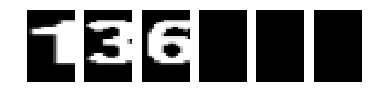

In [25]:
test_source = cv2.imread("samples/test_score.png")
plt.imshow(test_source, cmap=plt.cm.gray)
plt.show()

test = rois(test_source, corner_cut_size=2) #, verbose=1)
digits = []
for digit in test:
    
    gray = cv2.cvtColor(digit[0], cv2.COLOR_BGR2GRAY)
    _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    resized = cv2.resize(bw_image, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
    print(digit[0].shape, resized.shape)
    digits.append(resized)

# test_images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in digits ]
show_all(digits)

test_images = [z.reshape((RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT)) for z in digits]

In [26]:
digits[0].shape

(30, 20)

In [27]:
test_images[0].shape

(600,)

In [28]:
flattened_images[0].shape

(600,)

In [29]:
from sklearn import svm

In [31]:
# naive try without params
clf = svm.NuSVC(nu=0.3)

In [32]:
%%time
clf.fit(flattened_images, classifications)

CPU times: user 9.12 s, sys: 292 ms, total: 9.41 s
Wall time: 9.41 s


NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.3, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)

In [33]:
# expect fail
for digit in test_images:
    predict = clf.predict([digit])
    print(predict)

[2]
[2]
[2]


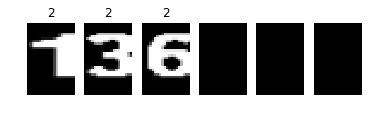

In [34]:
# just alternative display
predictions = [ clf.predict([z]).tolist() for z in test_images ]
show_all(digits, labels=[ str(z[0]) for z in predictions])

In [35]:
# Grid search

def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [36]:
# ### more_params = {'clf__nu' : [0.3, 0.28, 0.25, 0.23, 0.22, 0.2, 0.15],  - waited 3 days, interrupted
# more_params = {'clf__nu' : [0.3, 0.225, 0.2,],
#             'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', ],
#             'clf__shrinking' : [True, False],
# ###            'clf__tol' : [0.01, 0.003, 0.001, 0.0003, 0.0001],
#             'clf__tol' : [0.01, 0.001, 0.0001],
#             'clf__decision_function_shape' : ['ovo', 'ovr'],
#         }

In [37]:
more_params = {'clf__nu' : [0.3, 0.225, 0.2,],
            'clf__kernel' : ['linear'],
            'clf__shrinking' : [False],
###            'clf__tol' : [0.01, 0.003, 0.001, 0.0003, 0.0001],
            'clf__tol' : [0.01, 0.001, 0.0001],
            'clf__decision_function_shape' : ['ovo'],
        }

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [39]:
# # need more samples to have the CV
# double_samples = np.concatenate((flattened_images, flattened_images), axis=0)
# double_classes = np.concatenate((classifications, classifications), axis=0)

In [40]:
def grid_search():
    params = {
        'clf__random_state' : [1337]
    }

    params.update(more_params)

    pipeline = Pipeline([
        ('clf', svm.NuSVC())
    ])

    grid_search = GridSearchCV(pipeline, param_grid=params, cv=2, n_jobs=4)

    grid_search.fit(flattened_images, classifications )
    report(grid_search.cv_results_)

In [41]:
%%time
grid_search()

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.3, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.01}

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.3, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.001}

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.3, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.0001}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.225, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.01}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_functi

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.3, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.01}

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.3, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.001}

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.3, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.0001}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.225, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.01}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.225, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.001}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.225, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.0001}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.2, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.01}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.2, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.001}

Model with rank: 4
Mean validation score: 0.986 (std: 0.001)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.2, 'clf__random_state': 1337, 'clf__shrinking': False, 'clf__tol': 0.0001}

CPU times: user 9.34 s, sys: 15.5 ms, total: 9.35 s
Wall time: 37.6 s

In [51]:
more_params = {'clf__nu' : [0.3, 0.29, 0.26],
            'clf__kernel' : ['poly'],
            'clf__shrinking' : [True],
           'clf__tol' : [0.01, 0.003, 0.001],
            'clf__decision_function_shape' : ['ovo'],
        }

In [52]:
def grid_search():
    params = {
        'clf__random_state' : [1337]
    }

    params.update(more_params)

    pipeline = Pipeline([
        ('clf', svm.NuSVC())
    ])

    grid_search = GridSearchCV(pipeline, param_grid=params, cv=2, n_jobs=4)

    grid_search.fit(flattened_images, classifications )
    report(grid_search.cv_results_)

In [53]:
%%time
grid_search()

KeyboardInterrupt: 

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'clf__nu': 0.3, 'clf__random_state': 1337, 'clf__shrinking': True, 'clf__tol': 0.003}

...
CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 2min 40s

In [ ]:
=-=--=-==--==--=--

Use the results from the grid search above to fill in the next training model:

In [54]:
clf = svm.NuSVC(decision_function_shape='ovo', kernel='linear', nu=0.3, random_state=1337, shrinking=True, tol=0.003)
clf.fit(flattened_images, classifications)

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, nu=0.3, probability=False, random_state=1337,
   shrinking=True, tol=0.003, verbose=False)

reminder of the test sample

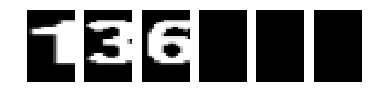

In [56]:
show_all(digits)

use the model to predict the test sample

In [58]:
for digit in test_images:
    predict = clf.predict([digit])
    print(predict)

[1]
[3]
[6]


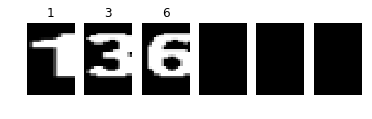

In [60]:
# just alternative display
predictions = [ clf.predict([z]).tolist() for z in test_images ]
show_all(digits, labels=[ str(z[0]) for z in predictions])

SAVE it

In [63]:
import pickle
with open('score_model2.pickle', 'wb') as f:
    pickle.dump(clf, f)

with open('score_model2.pickle', 'rb') as f:
    clf2 = pickle.load(f)
first_digit = clf2.predict([test_images[0]])
print('first digit of the score sample is', first_digit)

first digit of the score sample is [1]


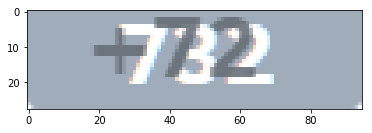

(28, 13, 3) (30, 20)
(28, 12, 3) (30, 20)
(28, 14, 3) (30, 20)


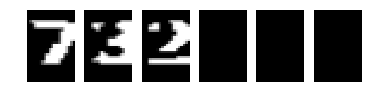

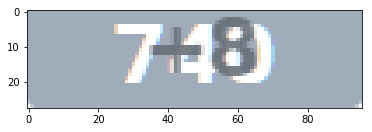

(28, 13, 3) (30, 20)
(28, 11, 3) (30, 20)
(28, 14, 3) (30, 20)


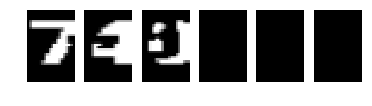

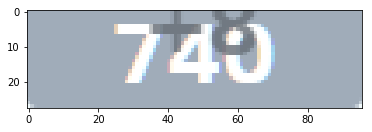

(28, 13, 3) (30, 20)
(28, 15, 3) (30, 20)
(28, 14, 3) (30, 20)


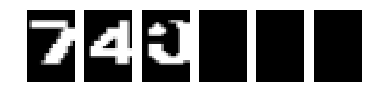

In [86]:
test_sources = [
    cv2.imread("samples/sample_103.png"),
    cv2.imread("samples/sample_104.png"),
    cv2.imread("samples/sample_105.png"),
]

samples = []
for test_source in test_sources:
    plt.imshow(test_source, cmap=plt.cm.gray)
    plt.show()

    test = rois(test_source, corner_cut_size=2) #, verbose=1)
    digits = []
    for digit in test:

        gray = cv2.cvtColor(digit[0], cv2.COLOR_BGR2GRAY)
        _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
        resized = cv2.resize(bw_image, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
        print(digit[0].shape, resized.shape)
        digits.append(resized)

    # test_images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in digits ]
    show_all(digits)

    samples.append((digits, [z.reshape((RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT)) for z in digits]))


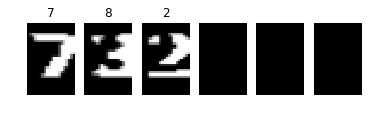

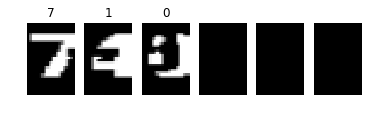

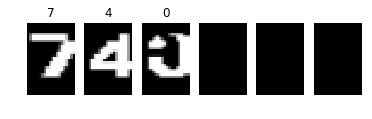

In [88]:
for digits, test_images in samples:
    predictions = [ clf.predict([z]).tolist() for z in test_images ]
    show_all(digits, labels=[ str(z[0]) for z in predictions])